<a href="https://colab.research.google.com/github/sarahajbane/notebooks/blob/main/car_shapes_supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import  MinMaxScaler, LabelEncoder


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Import and clean data

In [3]:
data = !wget -O 'data.csv' 'https://drive.google.com/uc?id=1MnXNtmjQcFjAtM4IUrGlPY3_P820cRD3'
df = pd.read_csv("/content/data.csv")
df.head()

# OR load from local current directory or drive content folder if already present & connected
# df = pd.read_csv("./vehicle.csv")

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  846 non-null    int64  
 1   circularity                  841 non-null    float64
 2   distance_circularity         842 non-null    float64
 3   radius_ratio                 840 non-null    float64
 4   pr.axis_aspect_ratio         844 non-null    float64
 5   max.length_aspect_ratio      846 non-null    int64  
 6   scatter_ratio                845 non-null    float64
 7   elongatedness                845 non-null    float64
 8   pr.axis_rectangularity       843 non-null    float64
 9   max.length_rectangularity    846 non-null    int64  
 10  scaled_variance              843 non-null    float64
 11  scaled_variance.1            844 non-null    float64
 12  scaled_radius_of_gyration    844 non-null    float64
 13  scaled_radius_of_gyr

In [5]:
df.isna().sum()

,0
compactness,0
circularity,5
distance_circularity,4
radius_ratio,6
pr.axis_aspect_ratio,2
max.length_aspect_ratio,0
scatter_ratio,1
elongatedness,1
pr.axis_rectangularity,3
max.length_rectangularity,0


In [6]:
df.duplicated().sum()

np.int64(0)

All NaNs are float64, but all floats seem to be integers (.0 only). Few NaNs overall and no fractions, so better to drop the NaNs than impute non-floats or turn all numerical data into integers before imputation.

In [7]:
df.dropna(inplace=True)  # Drop NaN values from df
df.to_csv("./clean_vehicle.csv", index=False)  # Save the cleaned dataframe to a new CSV file

## EDA

In [8]:
# Reload the cleaned dataframe if necessary
# df = pd.read_csv("./clean_vehicle.csv")

In [9]:
df['class'].unique()

array(['van', 'car', 'bus'], dtype=object)

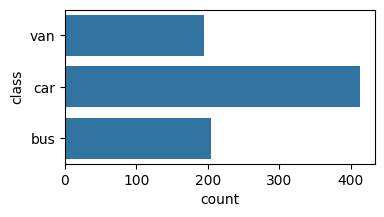

In [10]:
plt.figure(figsize=(4, 2))
sns.countplot(df['class'])
plt.show()

Data seems a little unbalanced off the bat with twice as many cars as buses and vans, due to combining two car types in the same class.

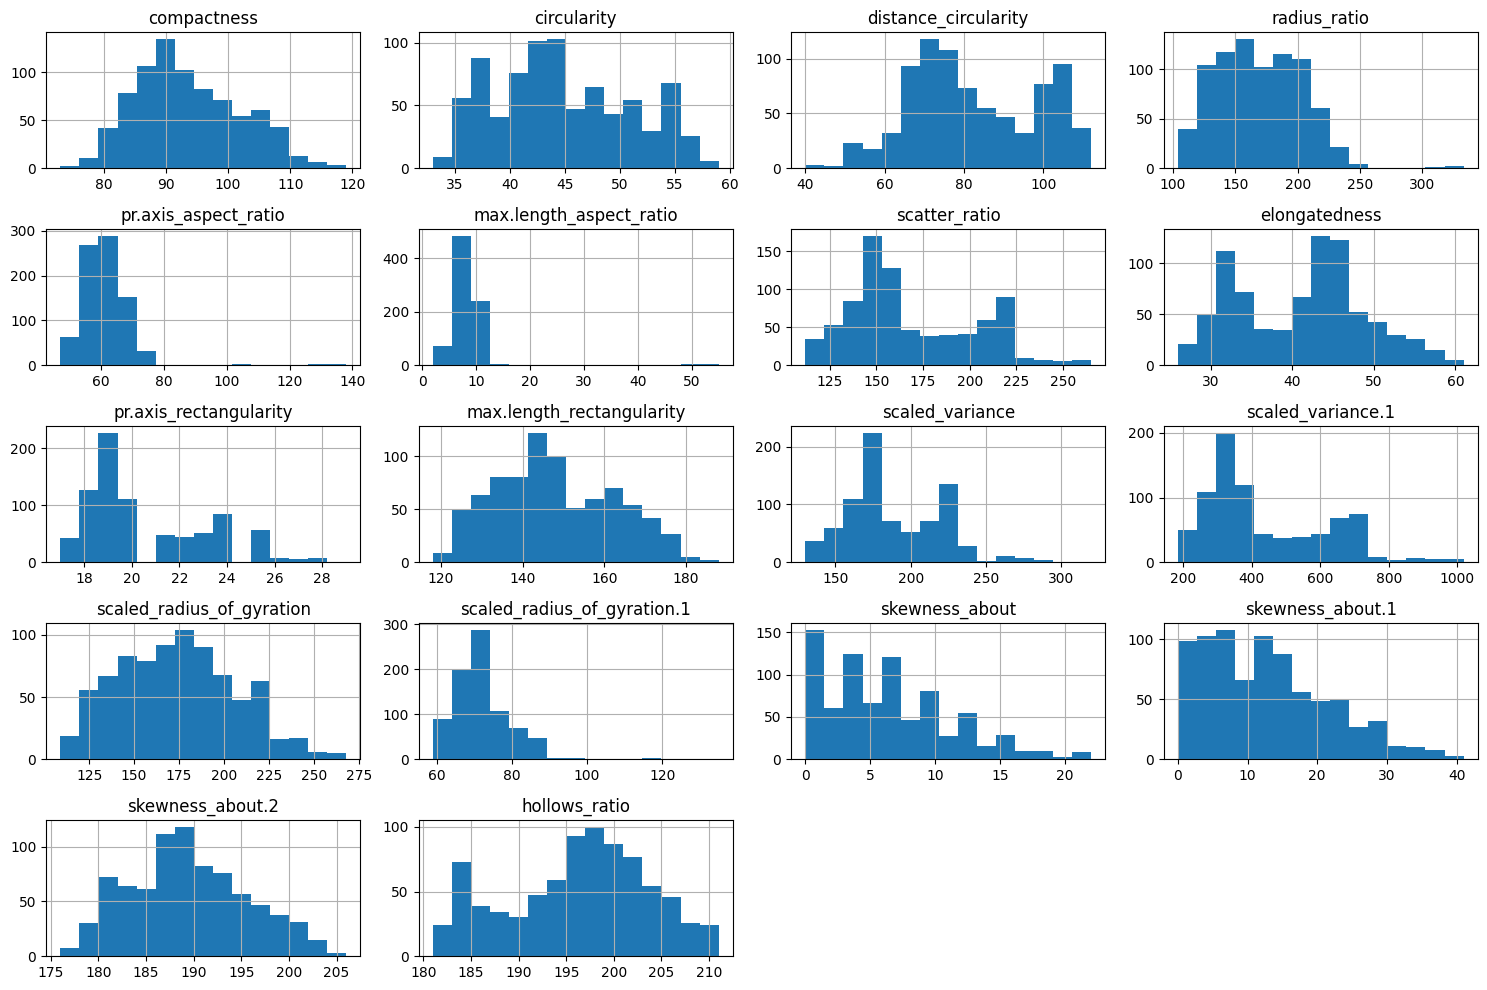

In [11]:
df.hist(figsize=(15, 10), bins=15)
plt.tight_layout()

pr.axis_rectangularly might deliniate the different classes but unclear from this figure alone, and counts seem off.

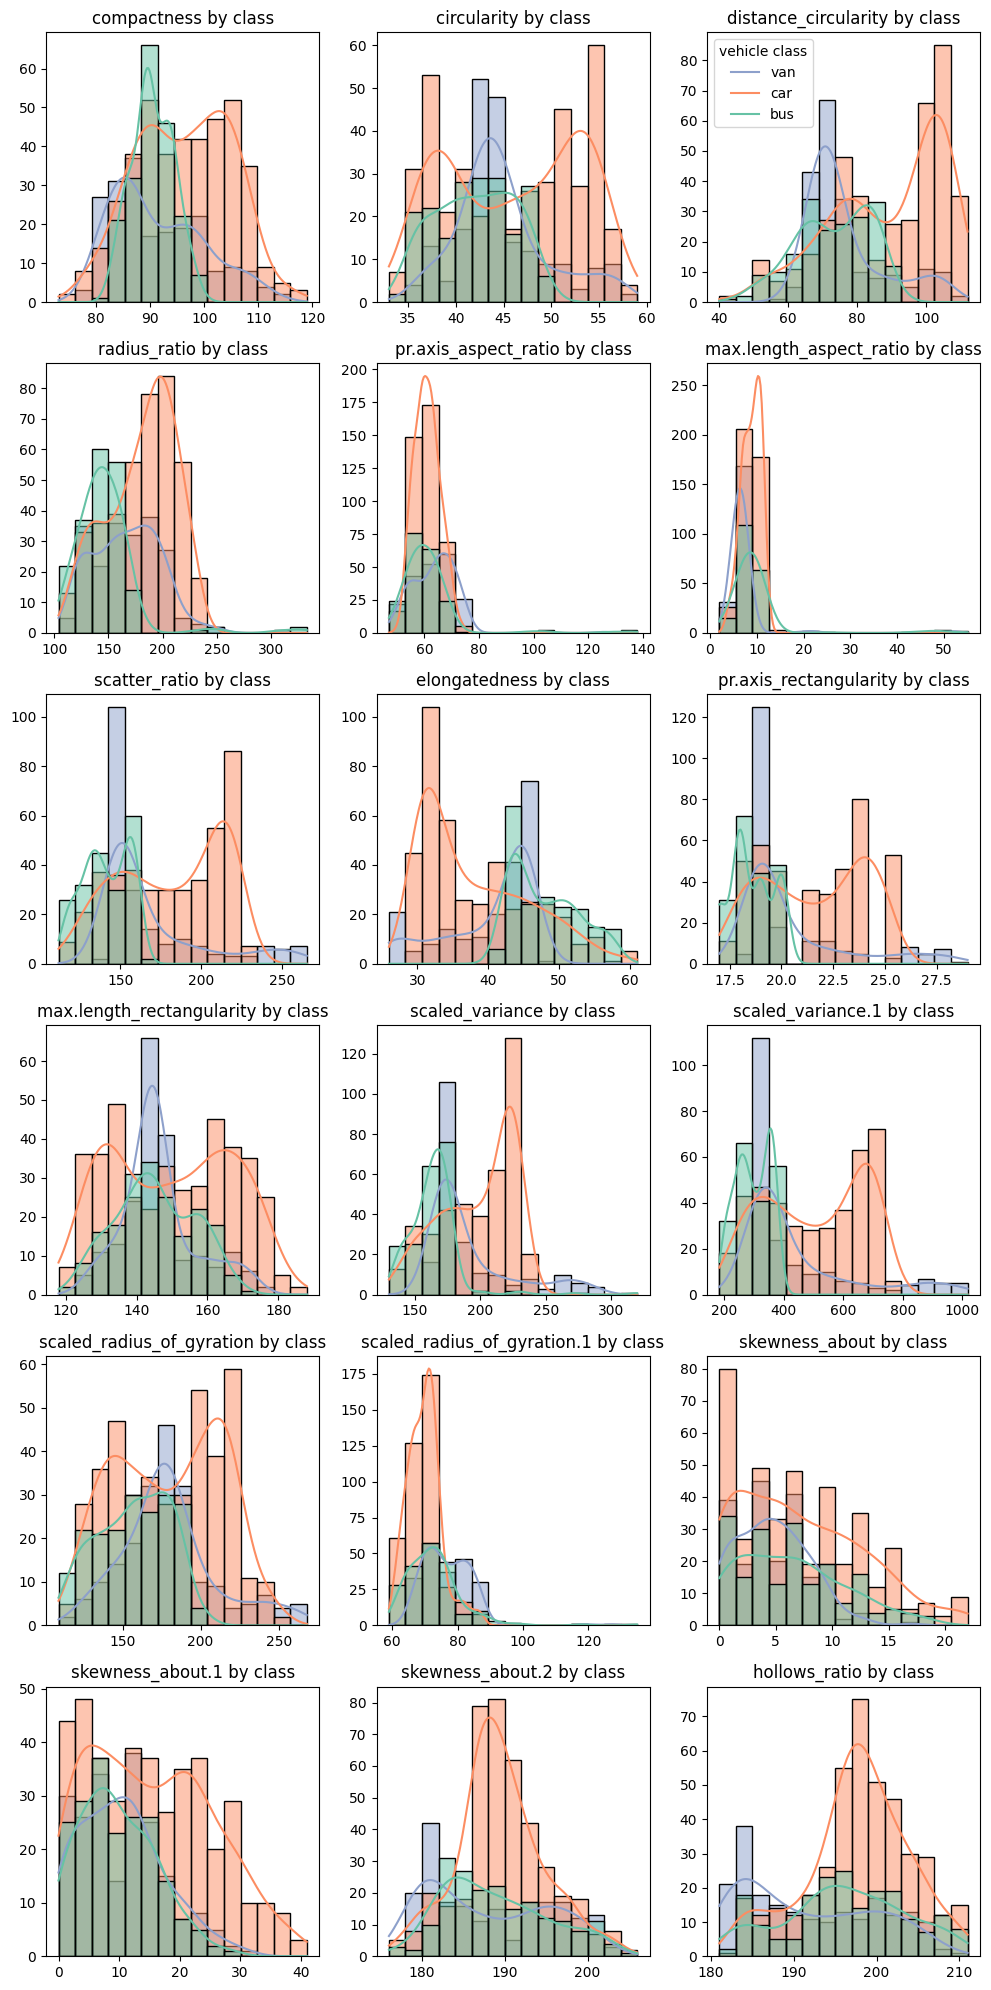

In [12]:
# replot histograms with class colour and kde to understand distribution of each category

i = 0  # Initialize the subplot index
plt.figure(figsize=(10, 20))
for column in df.drop(columns=['class']).columns:
    plt.subplot(6, 3, i + 1)
    sns.histplot(data=df, x=column, hue='class', bins=15, kde=True, palette='Set2')
    plt.title(f'{column} by class')
    plt.xlabel('')
    plt.ylabel('')
    if column == 'distance_circularity':
        plt.legend(title='vehicle class', loc='upper left', labels=df['class'].unique())
    else:
        plt.legend([],[], frameon=False)
    plt.tight_layout()
    i += 1  # Increment the subplot index

plt.show()

no clear separation in distribution between the classes. Higher peaks for cars are just an artefact of the class being twice as numerous.
Will need to use a model using all features to predict the class, as none stand out in particular for feature selection, and 18 are manageable.

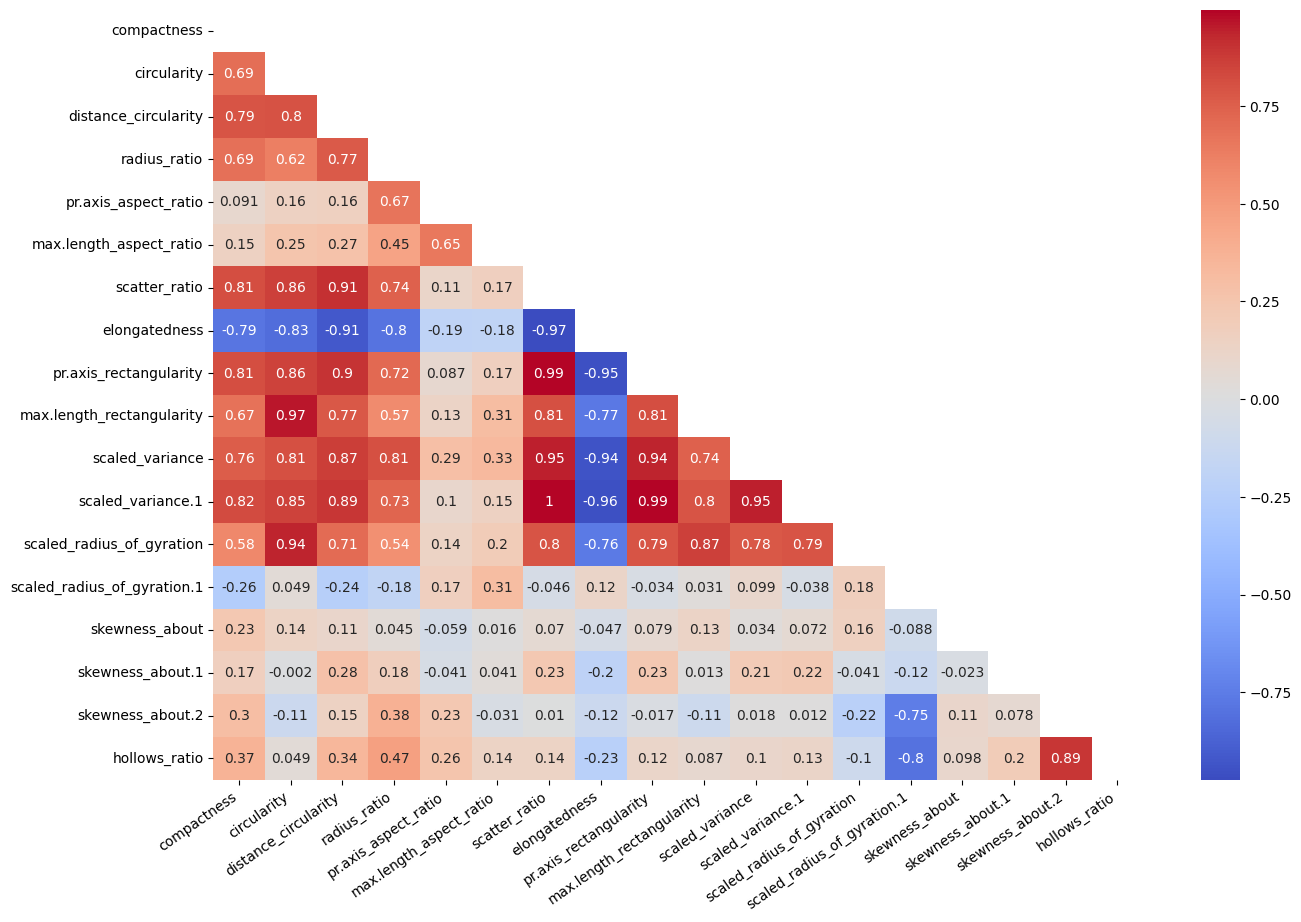

In [13]:
plt.figure(figsize=(15, 10))
mask = np.zeros_like(df.drop(columns=['class']).corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.drop(columns=['class']).corr(), annot=True, cmap='coolwarm', mask=mask)
plt.xticks(rotation=35, ha='right')
plt.show()

Ignoring the labelled targets, features of circularity, rectangularity, and elongatedness have strong correlations with each other and features of skewedness, variance and scatter/hollows ratio, but the meaning of the latter or how they are derived is unclear/unknown.


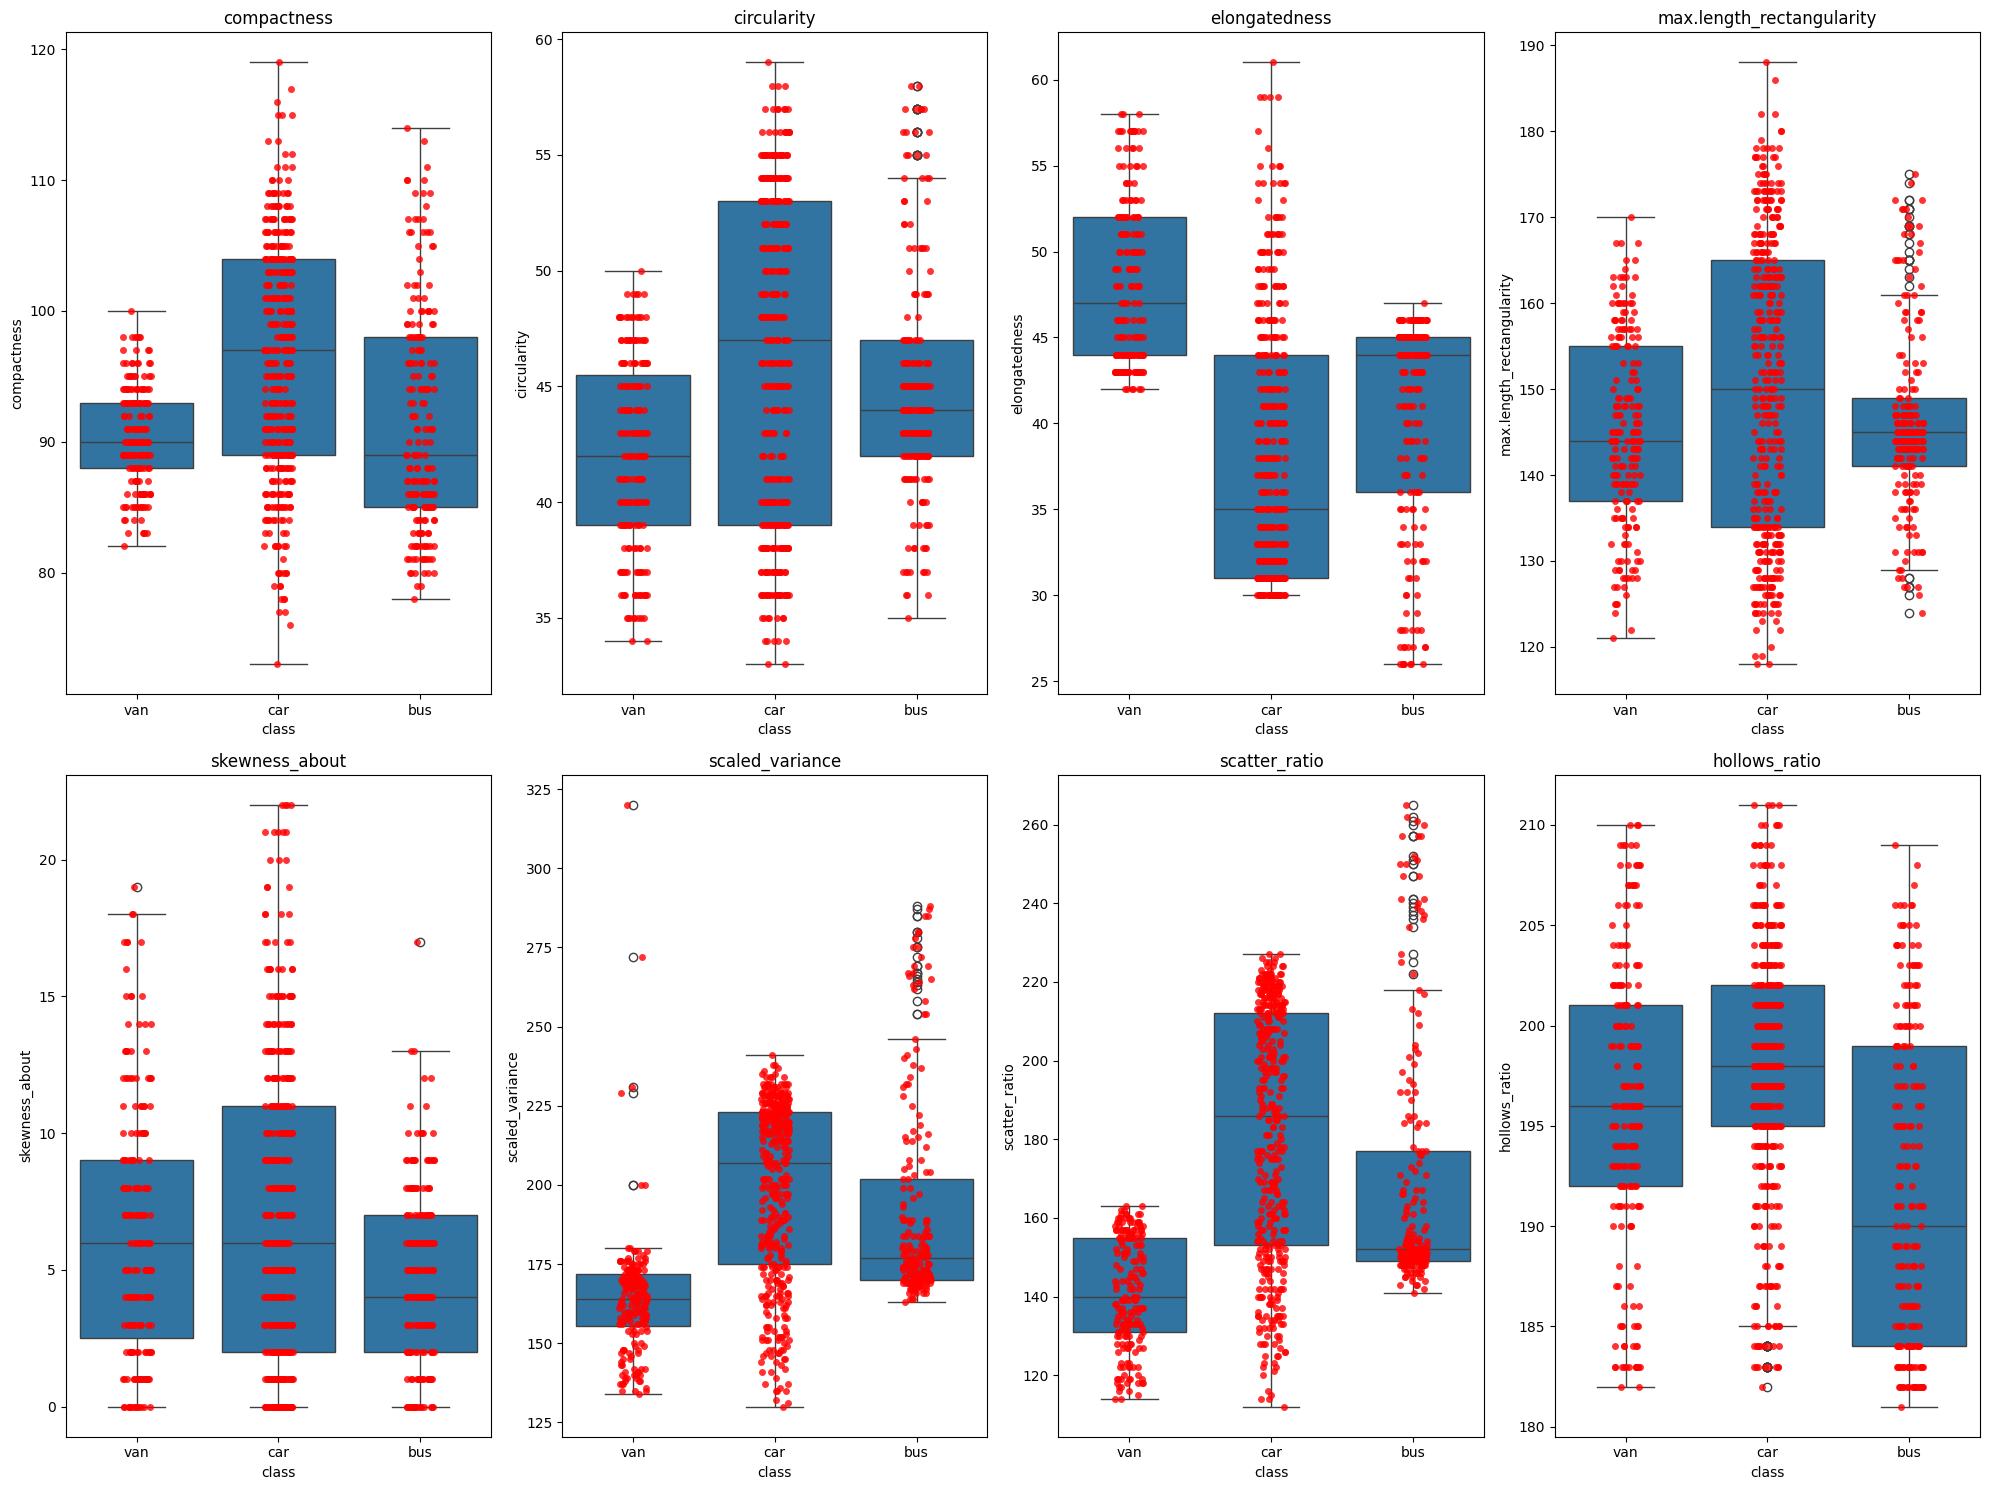

In [14]:
# Look at boxplots by car type with scatter to complete the EDA
selected_features = ['compactness','circularity', 'elongatedness', 'max.length_rectangularity',
                     'skewness_about', 'scaled_variance', 'scatter_ratio','hollows_ratio']

plt.figure(figsize=(20, 15))
num_columns = 4
num_rows = 2

for i, feature in enumerate(selected_features):
    plt.subplot(num_rows, num_columns, i + 1)
    sns.boxplot(x='class', y=feature, data=df)
    sns.stripplot(x = 'class', y = feature, data = df,
              jitter=True,
              marker='o',
              alpha=0.8,
              color="red")
    plt.title(feature)

plt.tight_layout()
plt.show()

Nothing obviously different here between the 3 target classes, but scatter_ratio and scaled_variance show some more significant clustered patterns for cars and bus types.

## Split and pre-process data for model training and testing

In [15]:
#Scale the feature data
scaler = MinMaxScaler()
X = df.drop(columns=['class'])  # Features
y = df['class']  # Target
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio
0,0.478261,0.576923,0.597222,0.323144,0.274725,0.150943,0.326797,0.457143,0.250000,0.585714,0.242105,0.233813,0.471698,0.144737,0.272727,0.390244,0.366667,0.533333
1,0.391304,0.307692,0.611111,0.161572,0.109890,0.132075,0.241830,0.542857,0.166667,0.357143,0.210526,0.175060,0.308176,0.171053,0.409091,0.341463,0.433333,0.600000
2,0.673913,0.653846,0.916667,0.458515,0.208791,0.150943,0.620915,0.171429,0.500000,0.571429,0.489474,0.540767,0.698113,0.184211,0.636364,0.219512,0.400000,0.500000
3,0.434783,0.307692,0.583333,0.240175,0.175824,0.132075,0.209150,0.571429,0.166667,0.357143,0.157895,0.149880,0.113208,0.052632,0.272727,0.243902,0.766667,0.866667
4,0.260870,0.423077,0.416667,0.441048,0.615385,0.943396,0.241830,0.542857,0.166667,0.371429,0.584211,0.169065,0.496855,0.894737,0.409091,0.268293,0.133333,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,0.434783,0.230769,0.652778,0.344978,0.186813,0.113208,0.372549,0.400000,0.250000,0.228571,0.368421,0.285372,0.251572,0.171053,0.318182,0.609756,0.400000,0.466667
809,0.347826,0.500000,0.611111,0.257642,0.208791,0.169811,0.307190,0.485714,0.250000,0.585714,0.226316,0.220624,0.421384,0.171053,0.045455,0.487805,0.333333,0.533333
810,0.717391,0.807692,0.847222,0.515284,0.219780,0.188679,0.718954,0.114286,0.666667,0.785714,0.515789,0.643885,0.572327,0.144737,0.136364,0.097561,0.366667,0.666667
811,0.282609,0.115385,0.527778,0.183406,0.120879,0.094340,0.150327,0.685714,0.083333,0.085714,0.131579,0.103118,0.245283,0.092105,0.000000,0.609756,0.466667,0.466667


In [16]:
#split data into features, target, test, and train
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

In [17]:
# assign numeric class through encoder
enc = LabelEncoder()
y_train_encoded = enc.fit_transform(y_train)
y_train_encoded[:10]

array([1, 1, 2, 1, 1, 1, 1, 0, 1, 1])

In [18]:
#same for test set
y_test_encoded = enc.fit_transform(y_test)
y_test_encoded[:10]

array([1, 2, 0, 2, 1, 2, 2, 0, 2, 1])

## Try different classification models to find the best results

In [19]:
lr = LogisticRegression(max_iter=10000, random_state=42, multi_class='ovr')
knn = KNeighborsClassifier()
svm = SVC(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rfc = RandomForestClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)

In [20]:
lr_model = make_pipeline(lr)
knn_model = make_pipeline(knn)
svm_model = make_pipeline(svm)
dtc_model = make_pipeline(dt)
rfc_model = make_pipeline(rfc)
abc_model = make_pipeline(ada)

In [21]:
lr_model.fit(X_train, y_train_encoded)
knn_model.fit(X_train, y_train_encoded)
svm_model.fit(X_train, y_train_encoded)
dtc_model.fit(X_train, y_train_encoded)
rfc_model.fit(X_train, y_train_encoded)
abc_model.fit(X_train, y_train_encoded)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('adaboostclassifier', AdaBoostClassifier(random_state=42))])

In [22]:
# quick look at feature importances - highest are scaled_variance.1 and elongatedness
rfc_model.fit(X_train, y_train)
rfc_model.named_steps['randomforestclassifier'].feature_importances_

array([0.03917502, 0.03613164, 0.07674402, 0.03034875, 0.05891556,
       0.1374236 , 0.07117733, 0.0748284 , 0.03105663, 0.0785104 ,
       0.06523823, 0.09684476, 0.02683605, 0.05013684, 0.02261103,
       0.02123729, 0.03582739, 0.04695708])

In [23]:
print( f"Logistic Regression: {lr_model.score(X_train, y_train_encoded)}")
print( f"KNN: {knn_model.score(X_train, y_train_encoded)}")
print( f"SVM: {svm_model.score(X_train, y_train_encoded)}")
print( f"Decision Tree: {dtc_model.score(X_train, y_train_encoded)}")
print( f"Random Forest: {rfc_model.score(X_train, y_train_encoded)}")
print( f"AdaBoost: {abc_model.score(X_train, y_train_encoded)}")

Logistic Regression: 0.9753846153846154
KNN: 0.9092307692307692
SVM: 0.6676923076923077
Decision Tree: 1.0
Random Forest: 0.0
AdaBoost: 0.8384615384615385


DecisionTreeClassifier and RandomForestClassifier have the highest accuracy scores, both with 100%. Danger of overfitting, so we will test all the models for evaluation. Logistic Regression also performs very well.

## Evaluate the models

In [24]:
names = ['Logistic Regression', 'KNN', 'SVM', 'Decision Tree', 'Random Forest', 'AdaBoost']
classifiers = [lr_model, knn_model, svm_model, dtc_model, rfc_model, abc_model]

scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)

df_models = pd.DataFrame()
df_models['name'] = names
df_models['score'] = scores
cm = sns.light_palette("brown", as_cmap=True)
s = df_models.style.background_gradient(cmap=cm)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Both tree based models still performed well on the test data, but Logistic Regression showed the highest accuracy and smallest drop for the test set.
Random Forest had the second highest accuracy score of 0.95, while Decision Tree dropped to 0.9.
The other models had scores between 0.68 and 0.87.

In [25]:
# Classification report for best 3 models
print(f"Logistic Regression:\n{classification_report(y_test, lr_model.predict(X_test))}")
print(f"Random Forrest Classification:\n{classification_report(y_test, rfc_model.predict(X_test))}")
print(f"Decision Tree Classification:\n{classification_report(y_test, dtc_model.predict(X_test))}")

Logistic Regression:
              precision    recall  f1-score   support

         bus       1.00      0.98      0.99        41
         car       0.96      0.99      0.98        83
         van       0.97      0.95      0.96        39

    accuracy                           0.98       163
   macro avg       0.98      0.97      0.97       163
weighted avg       0.98      0.98      0.98       163

Random Forrest Classification:
              precision    recall  f1-score   support

         bus       1.00      0.98      0.99        41
         car       0.97      0.93      0.95        83
         van       0.86      0.97      0.92        39

    accuracy                           0.95       163
   macro avg       0.95      0.96      0.95       163
weighted avg       0.95      0.95      0.95       163

Decision Tree Classification:
              precision    recall  f1-score   support

         bus       0.94      0.83      0.88        41
         car       0.84      0.95      0.89    

Logistic Regression has the highest accuracy overall, incl. average precision, recall, and f-1 scores for the different vehicle classes, whereas Random Forrest performs a bit worse on classifying vans, and Decision Tree struggles comparatively more with cars.

In [26]:
y_pred = rfc_model.predict(X_test)
accuracy_score(y_pred, y_test)

0.950920245398773

In [27]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Reassign numeric class through encoder
    # enc = LabelEncoder()
    # y_train = enc.fit_transform(y_train)
    # y_test = enc.fit_transform(y_test)

    # Train predictions
    train_pred = model.predict(X_train)

    # Test predictions
    test_pred = model.predict(X_test)

    # Train confusion matrix
    train_conf_matrix = confusion_matrix(y_train, train_pred)
    print("\nTrain Confusion Matrix:")
    print(train_conf_matrix)

    # Test confusion matrix
    test_conf_matrix = confusion_matrix(y_test, test_pred)
    print("\nTest Confusion Matrix:")
    print(test_conf_matrix)
    return train_pred, test_pred, train_conf_matrix, test_conf_matrix


In [28]:
train_pred_lr, test_pred_lr, train_conf_matrix_lr, test_conf_matrix_lr = evaluate_model(lr_model, X_train, y_train, X_test, y_test)


Train Confusion Matrix:
[[160   4   0]
 [  5 323   2]
 [  2   3 151]]

Test Confusion Matrix:
[[40  1  0]
 [ 0 82  1]
 [ 0  2 37]]


In [29]:
# Min-max scale the confusion matrices
train_conf_matrix_scaled = (train_conf_matrix_lr - np.min(train_conf_matrix_lr)) / (np.max(train_conf_matrix_lr) - np.min(train_conf_matrix_lr))
test_conf_matrix_scaled = (test_conf_matrix_lr - np.min(test_conf_matrix_lr)) / (np.max(test_conf_matrix_lr) - np.min(test_conf_matrix_lr))


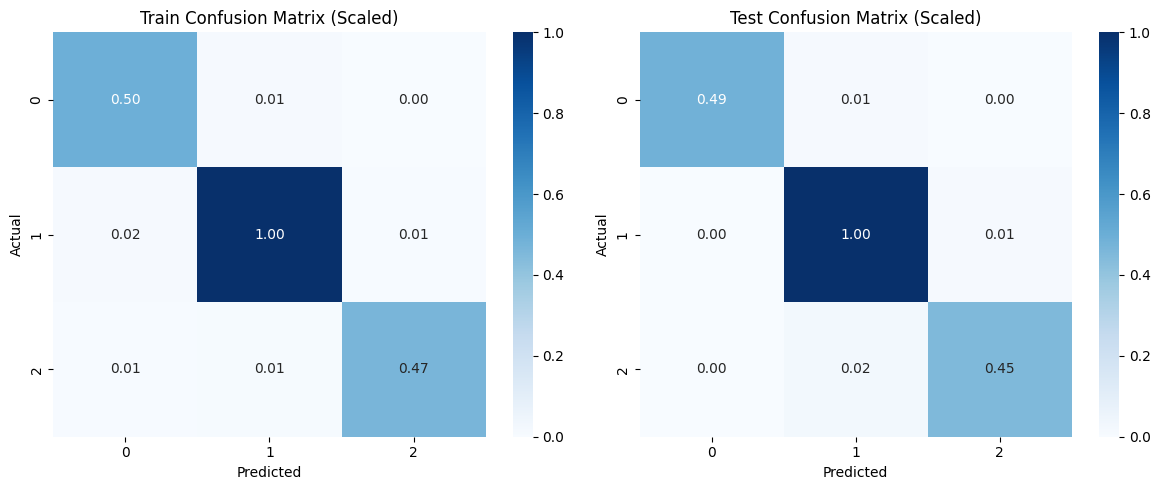

In [30]:
# Plot the heatmaps of the confusion matrices

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(train_conf_matrix_scaled , annot=True, fmt=".2f", cmap="Blues", ax=axes[0])
axes[0].set_title("Train Confusion Matrix (Scaled)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(test_conf_matrix_scaled , annot=True, fmt=".2f", cmap="Blues", ax=axes[1])
axes[1].set_title("Test Confusion Matrix (Scaled)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

Something seems wrong here.

In [31]:
# Train ROC AUC score
train_pred_proba = lr_model.predict_proba(X_train)
train_roc_auc = roc_auc_score(y_train_encoded, train_pred_proba, multi_class='ovr')
print("\nTrain ROC AUC Score:", train_roc_auc)

# Test ROC AUC score
test_pred_proba = lr_model.predict_proba(X_test)
test_roc_auc = roc_auc_score(y_test_encoded, test_pred_proba, multi_class='ovr')
print("Test ROC AUC Score:", test_roc_auc)


Train ROC AUC Score: 0.9980200369097155
Test ROC AUC Score: 0.9973162293508193


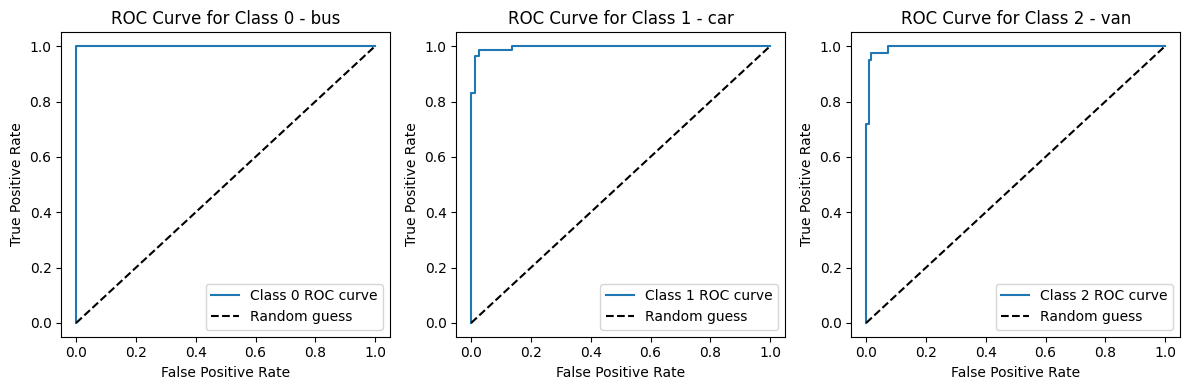

In [32]:
# plot ROC curve for each class
fpr = {}
tpr = {}
thresholds = {}
n_classes = test_pred_proba.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve((y_test_encoded == i).astype(int), test_pred_proba[:, i])


fig, axes = plt.subplots(1, n_classes, figsize=(12, 4))

for i, ax in enumerate(axes):
    ax.plot(fpr[i], tpr[i], label=f"Class {i} ROC curve")
    ax.plot([0, 1], [0, 1], 'k--', label='Random guess')
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"ROC Curve for Class {i} - {enc.classes_[i]}")
    ax.legend(loc="best")

plt.tight_layout()
plt.show()


## Decision made:

Happy with this result and should be a very good and simple model to use for car classification for the customer.

## Some hyperparameter tuning for Random Forrest Classifier & other Visualisations

In [33]:
param_grid = {'n_estimators': [50, 100, 150, 200],
              'max_depth': [10, 20, 30, 40, 50]}
grid = GridSearchCV(estimator=rfc,
                    param_grid=param_grid,
                    scoring='accuracy',
                    cv=5)

grid.fit(X_train, y_train)  # Fit the model
grid.best_params_  # Get the best parameters
grid.best_score_  # Get the best score
grid.best_estimator_  # Get the best estimator


RandomForestClassifier(max_depth=10, n_estimators=150, random_state=42)

In [34]:
max_features_range = np.arange(1,11,1)
n_estimators_range = np.arange(10,100,10)
param_grid = dict(max_features=max_features_range, n_estimators=n_estimators_range)

rf = RandomForestClassifier()

grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

grid.fit(X_train, y_train_encoded)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])})

In [35]:
print(f"The best parameters are {grid.best_params_}\nwith a score of {grid.best_score_:.2f}")


The best parameters are {'max_features': np.int64(4), 'n_estimators': np.int64(90)}
with a score of 0.96


Did not improve results a whole lot with the data currently at hand.

### Contour Plots for GridSeachCV

In [36]:
# plot contour plots for the grid search output anyway
grid_results = pd.concat([pd.DataFrame(grid.cv_results_["params"]),pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)
grid_results.head()

,max_features,n_estimators,Accuracy
0,1,10,0.920000
1,1,20,0.940000
2,1,30,0.936923
3,1,40,0.950769
4,1,50,0.952308


In [37]:
grid_contour = grid_results.groupby(['max_features','n_estimators']).mean()
grid_contour

Accuracy
max_features n_estimators          
1            10            0.920000
             20            0.940000
             30            0.936923
             40            0.950769
             50            0.952308
...                             ...
10           50            0.950769
             60            0.940000
             70            0.950769
             80            0.944615
             90            0.943077

[90 rows x 1 columns]

In [38]:
grid_reset = grid_contour.reset_index()
grid_reset

,max_features,n_estimators,Accuracy
0,1,10,0.920000
1,1,20,0.940000
2,1,30,0.936923
3,1,40,0.950769
4,1,50,0.952308
...,...,...,...
85,10,50,0.950769
86,10,60,0.940000
87,10,70,0.950769
88,10,80,0.944615


In [39]:
grid_pivot = grid_reset.pivot(index='max_features', columns='n_estimators', values='Accuracy')
grid_pivot

n_estimators,10,20,30,40,50,60,70,80,90
max_features,,,,,,,,,
1,0.920000,0.940000,0.936923,0.950769,0.952308,0.947692,0.949231,0.944615,0.941538
2,0.916923,0.936923,0.941538,0.953846,0.946154,0.949231,0.950769,0.949231,0.953846
3,0.932308,0.940000,0.947692,0.947692,0.955385,0.958462,0.955385,0.958462,0.961538
4,0.933846,0.952308,0.944615,0.941538,0.949231,0.944615,0.953846,0.947692,0.963077
5,0.933846,0.943077,0.955385,0.947692,0.953846,0.952308,0.952308,0.947692,0.956923
6,0.927692,0.944615,0.952308,0.944615,0.946154,0.950769,0.950769,0.953846,0.944615
7,0.935385,0.949231,0.952308,0.949231,0.949231,0.949231,0.944615,0.958462,0.952308
8,0.932308,0.949231,0.956923,0.949231,0.947692,0.952308,0.949231,0.946154,0.953846
9,0.936923,0.940000,0.943077,0.940000,0.943077,0.955385,0.947692,0.949231,0.946154


In [40]:
x = grid_pivot.columns.values
y = grid_pivot.index.values
z = grid_pivot.values

In [41]:
# 2D contour plot of accuracy
layout = go.Layout(
            xaxis=go.layout.XAxis(
              title=go.layout.xaxis.Title(
              text='n_estimators')
             ),
             yaxis=go.layout.YAxis(
              title=go.layout.yaxis.Title(
              text='max_features')
            ) )

fig = go.Figure(data = [go.Contour(z=z, x=x, y=y)], layout=layout )

fig.update_layout(title='Hyperparameter tuning', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

In [42]:
# 3D contour plot of accuracy

fig = go.Figure(data= [go.Surface(z=z, y=y, x=x)], layout=layout )
fig.update_layout(title='Hyperparameter tuning',
                  scene = dict(
                    xaxis_title='n_estimators',
                    yaxis_title='max_features',
                    zaxis_title='Accuracy'),
                  autosize=False,
                  width=800, height=800,
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

### Visualise Decision Tree

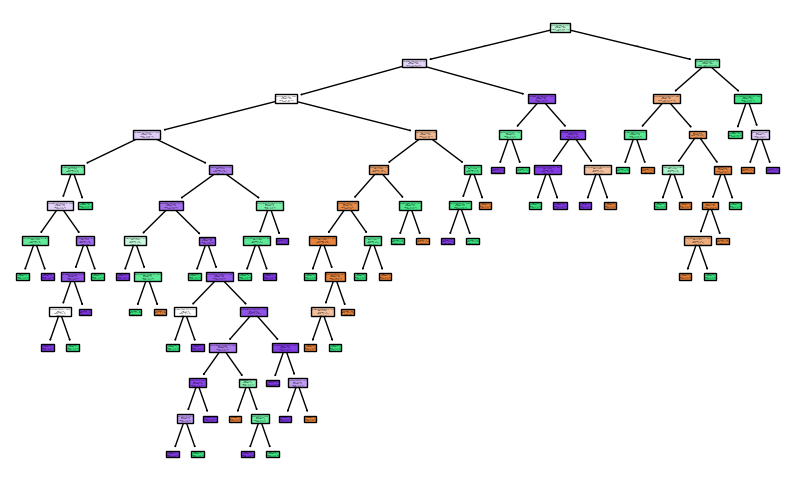

In [43]:
# Visualize the decision tree
plt.figure(figsize=(10, 6))
tree.plot_tree(dtc_model.named_steps['decisiontreeclassifier'], feature_names=X_train.columns, class_names=[str(el) for el in y_train.unique()], filled=True)
plt.show()